# Poetry Analysis

## Introduction
For my final project, I decided to analyze poetry data using computational methods. I found a [dataset](https://www.kaggle.com/ultrajack/modern-renaissance-poetry) on Kaggle that contains approximately five-hundred poems crawled from [PoetryFoundation](https://www.poetryfoundation.org/). These poems are from two time periods: Renaissance and modern; and three types are included: love, nature, and mythology & folklore. Using this dataset, I attempted to explore the differences and similarities among poems categorized by three features: the ages they were written, the types or themes, and the authors. I compared their word frequencies to extract the most distinctive words in a certain category and provided visualization and interpretations of the result.

Before analysis, the first step is to view my data and get familiar with its format and basic information.

In [1]:
# import the packages needed for subsequent analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

In [2]:
# load dataset and look at its format
poems = pd.read_csv('poems.csv')
poems.head()

,author,content,poem name,age,type
0,WILLIAM SHAKESPEARE,Let the bird of loudest lay\r\rOn the sole Ara...,The Phoenix and the Turtle,Renaissance,Mythology & Folklore
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,"Sir Charles into my chamber coming in,\r\rWhen...",An Epilogue to the Above,Renaissance,Mythology & Folklore
2,THOMAS BASTARD,"Our vice runs beyond all that old men saw,\r\r...","Book 7, Epigram 42",Renaissance,Mythology & Folklore
3,EDMUND SPENSER,"Lo I the man, whose Muse whilome did maske,\r\...","from The Faerie Queene: Book I, Canto I",Renaissance,Mythology & Folklore
4,RICHARD BARNFIELD,"Long have I longd to see my love againe,\r\rSt...",Sonnet 16,Renaissance,Mythology & Folklore


## Data Cleansing

First of all, I modified the column names so that they are more concise and accurate and would potentially be helpful in subsequent procedures. I also converted all the texts in the dataframe to lower cases to prepare for the analysis.

In [3]:
# rename the columns
poems.rename({'poem name': 'title', 'content': 'poem', 'author': 'poet'}, axis = 1, inplace = True)
# convert texts to lower case
poems= poems.apply(lambda x: x.str.lower())
poems.head()

,poet,poem,title,age,type
0,william shakespeare,let the bird of loudest lay\r\ron the sole ara...,the phoenix and the turtle,renaissance,mythology & folklore
1,duchess of newcastle margaret cavendish,"sir charles into my chamber coming in,\r\rwhen...",an epilogue to the above,renaissance,mythology & folklore
2,thomas bastard,"our vice runs beyond all that old men saw,\r\r...","book 7, epigram 42",renaissance,mythology & folklore
3,edmund spenser,"lo i the man, whose muse whilome did maske,\r\...","from the faerie queene: book i, canto i",renaissance,mythology & folklore
4,richard barnfield,"long have i longd to see my love againe,\r\rst...",sonnet 16,renaissance,mythology & folklore


Then I checked whether there are NAN values in the dataset.

In [4]:
poems.isna().sum() # check NA values in each column

poet     0
poem     0
title    2
age      0
type     0
dtype: int64

It shows that there are two poems without titles. I decided to keep them because the titles are not crucial factors when analyzing poems.  
I needed to check whether there are poems that appear more than once; if the answer is "yes", I would have to eliminate the duplicated ones to avoid further problems. 

In [5]:
# how many poems are there in total
len(poems)

573

In [6]:
# check whether there are repeated poems
poems.title.value_counts()

when i was fair and young                                         3
to a greek marble                                                 3
canto iv                                                          3
song                                                              3
sonnet 16                                                         2
                                                                 ..
my lute awake                                                     1
east rivers charm                                                 1
iambicum trimetrum                                                1
bilbea                                                            1
amoretti lxxxi: fayre is my love, when her fayre golden heares    1
Name: title, Length: 508, dtype: int64

The value_counts function shows the unique values with the number of rows that contain each value. By counting the unique titles, I found some poem titles appearing twice or three times. Many of them are likely to be the same poems, so it would be necessary to delete them. I deleted the duplicated poems with extactly the same texts instead of titles since different poems may happen to have the same titles.

In [7]:
poems = poems.drop_duplicates('poem') # delete the duplicates
len(poems)

506

I continued to explore the dataset by looking at how the data are distributed among different ages, types, and poets.

In [8]:
# the number of poems from each age
poems.age.value_counts()

renaissance    284
modern         222
Name: age, dtype: int64

In [9]:
# the number of poems of each type
poems.type.value_counts()

love                    278
nature                  169
mythology & folklore     59
Name: type, dtype: int64

In [10]:
poems.poet.unique() # look at all poets' names

array(['william shakespeare', 'duchess of newcastle margaret cavendish',
       'thomas bastard', 'edmund spenser', 'richard barnfield',
       'sir walter ralegh', 'queen elizabeth i', 'john donne',
       'john skelton', 'christopher marlowe', 'lady mary wroth',
       'robert southwell, sj', 'william byrd', 'george gascoigne',
       'henry viii, king of england', 'sir thomas wyatt', 'en jonson',
       'orlando gibbons', 'thomas nashe', 'sir philip sidney',
       'second baron vaux of harrowden thomas, lord vaux',
       'henry howard, earl of surrey', 'george chapman', 'thomas campion',
       'isabella whitney', 'samuel daniel', 'thomas heywood',
       'giovanni battista guarini', 'sir edward dyer', 'thomas lodge',
       'john fletcher', 'edgar lee masters', 'william butler yeats',
       'ford madox ford', 'ivor gurney', 'carl sandburg', 'ezra pound',
       'elinor wylie', 'george santayana', 'louise bogan',
       'kenneth slessor', 'hart crane', 'd. h. lawrence',
       'h

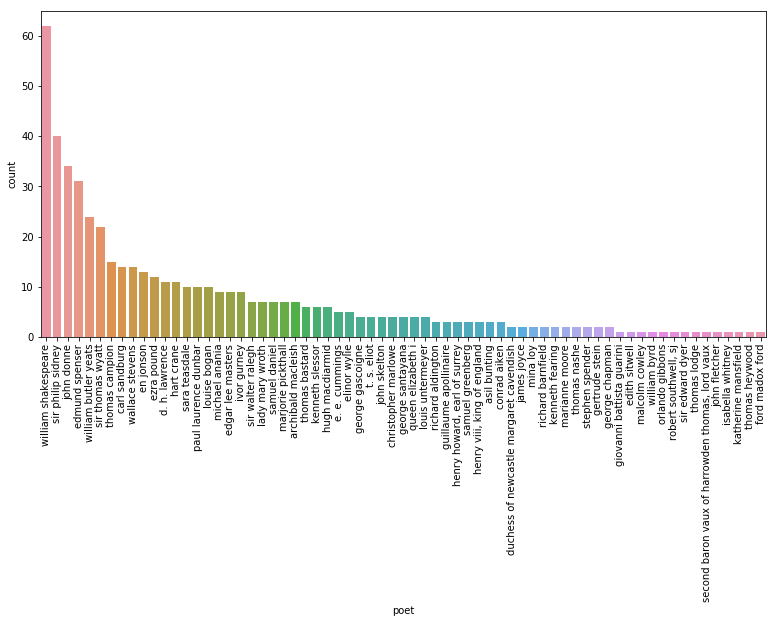

In [11]:
# plot of the number of poems by each poet
plt.figure(figsize=(13,6))
ax = sns.countplot(x='poet', data=poems, order=poems.poet.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

From the plot, we can see that 506 poems are unevenly distributed among 66 poets. There are more than 60 poems by Shakespeare, while for some poets only one poem is included. The potential problem is that if we are interested in these poets, the sample in this dataset may be too small to be representative of their styles. So if I want to analyze the styles of certain poets, I need to make sure to select those with more poems.

## Comparing the poems

### Renaissance Vs. Modern

I intended to compare poems from Renaissance and modern age by extracting the most frequent words used in them respectively.

I defined a function that selects texts based on the input dataframe and condition to construct a new dataframe with tokenized words, word frequencies, and the parts-of-speech tags of words. I can directly apply this function to both modern and Renaissance poems later. 

In [12]:
def word_freq(df, condition):
    # create a long string of all poems from the input age
    words = '\n'.join(df[condition].poem)
    # tokenize words and exclude punctuations
    words = [word for word in nltk.word_tokenize(words) if word.isalpha()] 
    df = pd.Series(nltk.FreqDist(words)).reset_index()
    df.columns = ['word','freq']
    # add the pos tags to dataframe
    df['tag'] = df.word.apply(lambda x: nltk.pos_tag([x], tagset="universal")).apply(lambda x: x[0][1])
    return(df)

In [13]:
# apply the function to modern poems
mod = word_freq(poems, poems.age =='modern')

# get the most frequent 10 words in modern poems
mod.sort_values('freq').tail(10)

,word,freq,tag
62,with,277,ADP
193,by,281,ADP
142,that,309,ADP
75,to,430,PRT
0,i,472,NOUN
244,in,500,ADP
16,a,556,DET
7,of,911,ADP
26,and,1168,CONJ
3,the,2062,DET


These words are not very "interesting" since they are common in any English texts and does not tell us anything about  modern poems. I then took a look at the nouns in particular, which may contain more information.

In [14]:
# the most frequent twenty nouns in modern poems
mod[mod.tag=='NOUN'].sort_values('freq', ascending = False)[:20]

,word,freq,tag
0,i,472,NOUN
363,love,83,NOUN
203,permission,79,NOUN
196,copyright,74,NOUN
95,heart,57,NOUN
189,poems,57,NOUN
1162,eyes,44,NOUN
540,night,43,NOUN
86,life,39,NOUN
163,man,39,NOUN


"I", "love"..."permission"? "copyright"? Surprisingly, the result shows a few words that are unlikely to appear in poems. It seems that there are something wrong with the dataset. I decided to probe into this problem. 

### Troubleshooting

First, I tried to draw out one of the poems that contains the problematic words and see what under what situations these words occur. 

In [15]:
poems[poems.poem.str.contains('copyright')].iloc[0,1]

'w. b. yeats, lapis lazuli from the poems of w. b. yeats: a new edition, edited by richard j. finneran. copyright 1933 by macmillan publishing company, renewed  1961 by georgie yeats. reprinted with the permission of a. p. watt, ltd. on behalf of michael yeats.'

It turned out that these 'poems' contain information about copyrights instead of the actual content of poems. I created a list of keywords that are likely to occur in such metadata and took a look at all rows in the dataset containing any of these words. 

In [16]:
w = ['permission','copyright','publish','edition','reprint'] # list of suspicious words
missing = poems[poems.poem.apply(lambda x: any(word in x for word in w))] # rows that contain any of the above words
missing

,poet,poem,title,age,type
12,edmund spenser,"by that he ended had his ghostly sermon,\r\rth...",prosopopoia: or mother hubbard's tale,renaissance,mythology & folklore
318,william butler yeats,"w. b. yeats, lapis lazuli from the poems of w....",lapis lazuli,modern,mythology & folklore
329,carl sandburg,"doors, from wind song, is copyright 1957 by c...",doors,modern,mythology & folklore
330,ezra pound,"ezra pound, ""canto i"" from the cantos of ezra ...",canto i,modern,mythology & folklore
331,ezra pound,"ezra pound, ""canto iii"" from the cantos of ezr...",canto iii,modern,mythology & folklore
...,...,...,...,...,...
533,asil bunting,"basil bunting, 30. the orotava road from compl...",from odes: 30. the orotava road,modern,love
538,louise bogan,"louise bogan, song for the last act from the b...",song for the last act,modern,love
539,d. h. lawrence,"originally published in poetry, december 1914.",song (love has crept...),modern,love
541,james joyce,"originally published in poetry, may 1917.",tutto sciolto,modern,love


It shows that there are 86 poems with missing contents, which is quite a large portion of our data. In order to solve this problem, I found another larger [database of poems on Kaggle](https://www.kaggle.com/tgdivy/poetry-foundation-poems) with nearly all the poems from PoetryFoundation. I attempted to use the poems in this large dataset to fill the missing contents in our dataframe.

In [17]:
all_poems = pd.read_csv('PoetryFoundationData.csv')
all_poems.head()

,Unnamed: 0,Title,Poem,Poet,Tags
0,0,\r\r\n Objects Used to Prop...,"\r\r\nDog bone, stapler,\r\r\ncribbage board, ...",Michelle Menting,NaN
1,1,\r\r\n The New Church\r\r\n...,"\r\r\nThe old cupola glinted above the clouds,...",Lucia Cherciu,NaN
2,2,\r\r\n Look for Me\r\r\n ...,\r\r\nLook for me under the hood\r\r\nof that ...,Ted Kooser,NaN
3,3,\r\r\n Wild Life\r\r\n ...,"\r\r\nBehind the silo, the Mother Rabbit\r\r\n...",Grace Cavalieri,NaN
4,4,\r\r\n Umbrella\r\r\n ...,\r\r\nWhen I push your button\r\r\nyou fly off...,Connie Wanek,NaN


The dataset contains similar information as ours except the age of poems, which does not matter here since we only need the texts. I made some modifications so that it matches the our "poems" dataframe, including the column names and texts format.

In [18]:
# convert the texts to lowercase & get rid of the spaces before and after the texts
all_poems.Title = all_poems.Title.str.lower().apply(str.strip)
all_poems.Poem = all_poems.Poem.str.lower().apply(str.strip)
all_poems.Poet = all_poems.Poet.str.lower()

# convert the column names to lower case to match our poems dataframe
all_poems.columns = map(str.lower, all_poems.columns)
all_poems.head()

,unnamed: 0,title,poem,poet,tags
0,0,objects used to prop open a window,"dog bone, stapler,\r\r\ncribbage board, garlic...",michelle menting,NaN
1,1,the new church,"the old cupola glinted above the clouds, shone...",lucia cherciu,NaN
2,2,look for me,look for me under the hood\r\r\nof that old ch...,ted kooser,NaN
3,3,wild life,"behind the silo, the mother rabbit\r\r\nhunche...",grace cavalieri,NaN
4,4,umbrella,when i push your button\r\r\nyou fly off the h...,connie wanek,NaN


Now it looks similar to our dataframe. I merged it with "missing" dataframe, matching the titles and authors of those missing poems and leaving out the rest of poems that we do not need.

In [19]:
merged = missing.merge(all_poems, how = 'left', on = ['title','poet'], suffixes=("_matadata", "_original"))
merged

,poet,poem_matadata,title,age,type,unnamed: 0,poem_original,tags
0,edmund spenser,"by that he ended had his ghostly sermon,\r\rth...",prosopopoia: or mother hubbard's tale,renaissance,mythology & folklore,146.0,"by that he ended had his ghostly sermon, the f...","Relationships,Pets,Arts & Sciences,Humor & Sat..."
1,william butler yeats,"w. b. yeats, lapis lazuli from the poems of w....",lapis lazuli,modern,mythology & folklore,90.0,(for harry clifton)\r\r\n\r\r\n\r\r\n\r\r\ni h...,"Arts & Sciences,Poetry & Poets,Mythology & Fol..."
2,carl sandburg,"doors, from wind song, is copyright 1957 by c...",doors,modern,mythology & folklore,90.0,"an open door says, “come in.”a shut door says,...","Living,Life Choices,Mythology & Folklore,Ghost..."
3,ezra pound,"ezra pound, ""canto i"" from the cantos of ezra ...",canto i,modern,mythology & folklore,62.0,"and then went down to the ship,\r\r\nset keel ...","Activities,Travels & Journeys,Social Commentar..."
4,ezra pound,"ezra pound, ""canto iii"" from the cantos of ezr...",canto iii,modern,mythology & folklore,63.0,i sat on the dogana’s steps\r\r\nfor the gondo...,"Activities,Travels & Journeys,Relationships,Fr..."
...,...,...,...,...,...,...,...,...
82,asil bunting,"basil bunting, 30. the orotava road from compl...",from odes: 30. the orotava road,modern,love,NaN,NaN,NaN
83,louise bogan,"louise bogan, song for the last act from the b...",song for the last act,modern,love,189.0,"now that i have your face by heart, i look \...","Living,Growing Old,Love,Classic Love,Heartache..."
84,d. h. lawrence,"originally published in poetry, december 1914.",song (love has crept...),modern,love,NaN,NaN,NaN
85,james joyce,"originally published in poetry, may 1917.",tutto sciolto,modern,love,NaN,NaN,NaN


It looks like we successfully obtained those poems we were looking for, but there are some NAN values showing that some poems could not be found in the large dataset.

In [20]:
# check how many poems are not found in all_poems
merged.isna().sum()

poet              0
poem_matadata     0
title             0
age               0
type              0
unnamed: 0       21
poem_original    21
tags             22
dtype: int64

21 of the missing poems failed to be matched. It is acceptable since we have found most of the missing ones. Again, I needed to check whether there are duplicated values and delete them if there were any, as I did before with the "poems" dataframe. Df.duplicated() function allows me to pull out the duplicates.

In [21]:
merged[merged.duplicated(['title','poet'])] # see duplicated poems with the same titles and poets

,poet,poem_matadata,title,age,type,unnamed: 0,poem_original,tags
52,wallace stevens,"wallace stevens, ""anecdote of a jar"" from coll...",anecdote of the jar,modern,nature,82.0,"i placed a jar in tennessee, \r\r\nand round...","Nature,Landscapes & Pastorals,Arts & Sciences,..."


In [22]:
merged = merged.drop_duplicates(['title','poet'], keep = 'first') # delete duplicated poem
len(merged)

86

Then I took the poems we found, which is the 'poem_original' column in 'merged' data frame, and replaced the false data with them by matching their indices.

In [23]:
# put the original poems found back into our poems dataframe
poems['poem'][missing.index] = merged.poem_original
# check the dataframe
poems.poem[missing.index] 

12     by that he ended had his ghostly sermon, the f...
318    (for harry clifton)\r\r\n\r\r\n\r\r\n\r\r\ni h...
329    an open door says, “come in.”a shut door says,...
330    and then went down to the ship,\r\r\nset keel ...
331    i sat on the dogana’s steps\r\r\nfor the gondo...
                             ...                        
533                                                  NaN
538    now that i have your face by heart, i look   \...
539                                                  NaN
541                                                  NaN
552    you have not conquered me—it is the surge\r\r\...
Name: poem, Length: 86, dtype: object

I needed to delete the unfound poems, which have NAN values.

In [24]:
poems.dropna(inplace=True)
poems.isna().sum()

poet     0
poem     0
title    0
age      0
type     0
dtype: int64

Finally, I solved the problems and could continue my analysis. I reapplied the word_freq function to modern poems.

In [25]:
mod = word_freq(poems, poems.age == 'modern')
mod[mod.tag=='NOUN'].sort_values('freq', ascending = False)[:20] # most frequent nouns in modern poems

,word,freq,tag
0,i,633,NOUN
998,s,124,NOUN
490,love,102,NOUN
163,man,86,NOUN
822,o,85,NOUN
95,heart,73,NOUN
352,eyes,70,NOUN
712,time,67,NOUN
436,wind,66,NOUN
50,light,65,NOUN


In [26]:
ren = word_freq(poems, poems.age == 'renaissance')
# the most frequent twenty nouns in renaissance poems
ren[ren.tag=='NOUN'].sort_values('freq', ascending = False)[:20]

,word,freq,tag
212,i,786,NOUN
79,love,461,NOUN
66,thy,362,NOUN
22,thou,317,NOUN
77,doth,219,NOUN
1003,thee,188,NOUN
793,ye,143,NOUN
1041,eyes,130,NOUN
1705,hath,125,NOUN
199,fair,123,NOUN


The nouns provide a better sense of what Renaissance poems generally look like. Many words reflect the features of Early Modern English, including "thy" and "hath", while some reveal the topics of the poems, such as "love" and "beauty".

In order to characterize how each word is "associated" with each age, I used the log-odds method that we have seen in lecture. First, I needed to merge two data frames into one that shows frequencies of each word in modern and Renaissance poems respectively.

In [27]:
# merge two dataframes
age = ren.merge(mod, how = 'left', on = ['word','tag'], suffixes = ('_ren','_mod'))
# convert NAN values to 0
age.fillna(0, inplace = True)

Then I defined a function to compute the log_odds between two frequency columns, which is calculated by getting the ratio of the proportions of each word in poems of each category and takes the log of it.

In [28]:
# define a function to compute log-odds
def log_odds(x,y):
    log = np.log(
    ((x+1)*(y.sum()+1))
    /
    ((y+1)*(x.sum()+1))
)
    return(log)
    
# apply the function to dataframe        
age['log_odds'] = log_odds(age.freq_mod, age.freq_ren)
age.head()

,word,freq_ren,tag,freq_mod,log_odds
0,let,165,VERB,40.0,-0.940922
1,the,1664,DET,3028.0,1.055902
2,bird,5,NOUN,31.0,2.131471
3,of,995,ADP,1233.0,0.671763
4,loudest,1,ADJ,1.0,0.457494


The log_odds column shows how much more likely a word is to be used in modern or renaissance poems. By sorting this column I got the most likely words for each age. A smaller value (negative) suggests that the word is more "renaissance" and the larger value (positive) indicates its "modernness" in poems.

In [29]:
age.sort_values('log_odds').head(20)

,word,freq_ren,tag,freq_mod,log_odds
77,doth,219,NOUN,3.0,-3.549839
2214,doe,44,NOUN,0.0,-3.349168
793,ye,143,NOUN,3.0,-3.126025
1585,goodly,30,ADV,0.0,-2.976493
351,thine,53,NOUN,1.0,-2.838343
2174,theyr,25,NOUN,0.0,-2.800602
4713,stella,24,NOUN,0.0,-2.761382
296,muse,24,NOUN,0.0,-2.761382
2247,fayre,23,NOUN,0.0,-2.720560
1922,wilt,23,NOUN,0.0,-2.720560


The smallest twenty log-odds give us the words that are most likely to occur in renaissance poems. While most of these words appear more than twenty times in renaissance poems (some even more than 100 times), they are so rare in modern poems that they almost never occur. The result is not surprising, since by looking at these words, we can immediately tell their "Shakespeareaness". Most of them are words in Early Modern forms of spelling that are different from how we use them now, like "fayre" and "doth". Some of them still remain in use today; they simply tend to be popular in Renaissance poems yet are somehow abandoned by modern poets, such as "muse" and "lullaby". In another words, these words indicate shifts in both word forms and poetic themes/imagery from Renaissance to modern time.
  
I also took a look at the most frequent words in modern poems. I filtered out those that appeared less than 15 times.

In [30]:
age[(age.freq_mod >= 15)].sort_values('log_odds').tail(20)

,word,freq_ren,tag,freq_mod,log_odds
1365,evening,4,VERB,26.0,2.143893
5219,hills,3,NOUN,21.0,2.162242
2947,beautiful,2,NOUN,16.0,2.192095
2263,stones,3,NOUN,22.0,2.206694
2918,water,9,NOUN,60.0,2.265783
5031,dark,8,NOUN,56.0,2.303321
5041,sang,2,NOUN,20.0,2.403404
263,beyond,2,ADP,22.0,2.494376
553,over,9,ADP,76.0,2.498715
5145,across,2,ADP,23.0,2.536936


It is interesting that all the words are also used in renaissance poems, even though infrequently. It shows that most the of words modern poets use were already in shape hundreds of years ago instead of newly invented.   
We can see the imagery that are popular in modern poems exclusively-- including "wave" "grass" and "stones"-- while they are unlikely to appear in Shakespear's sonnets. I am interested in the modern imagery, so I decided to visualize them. I selected 35 common nouns that appear more than 15 times in modern poems and are more than one-letter long. Then I defined a function to generate a word cloud and applied the function to my list of words.

In [31]:
mod_noun = age[(age.freq_mod >= 15) & (age.tag == 'NOUN') & (age.word.str.len() > 1)].sort_values('log_odds').tail(35)
mod_noun.head()

,word,freq_ren,tag,freq_mod,log_odds
4673,voice,7,NOUN,20.0,1.422575
4004,days,8,NOUN,23.0,1.438323
4963,broken,6,NOUN,18.0,1.456023
4696,moon,10,NOUN,29.0,1.460796
2893,beat,5,NOUN,16.0,1.498948


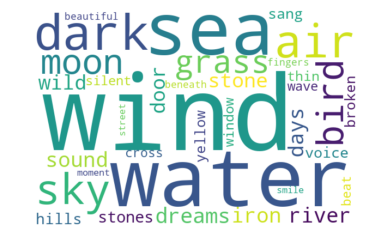

In [32]:
from wordcloud import WordCloud

# define a function that generates a word cloud with input dataframe and column names for both words and frequency
def wordcloud(df, word_col, freq_col):
    # create a dictionary of words and corresponding frequency
    d = {}
    for word, freq in df[[word_col,freq_col]].values:
        d[word] = freq
    # generate word cloud based on the word frequency and set its size and color
    wordcloud = WordCloud(height=400, width=600, background_color='White')
    wordcloud.generate_from_frequencies(frequencies=d) 
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# apply the function to my list of modern imagery
wordcloud(mod_noun, 'word','freq_mod')

I noticed that many of the images are related to natural environment, like "water," "wind," and "sky". It suggests that many of these poems may be centered around the topic of nature. I examined the observation by looking into the proportion of those tagged with the type "nature" in modern poems in our dataset and compare with that of Renaissance poems.

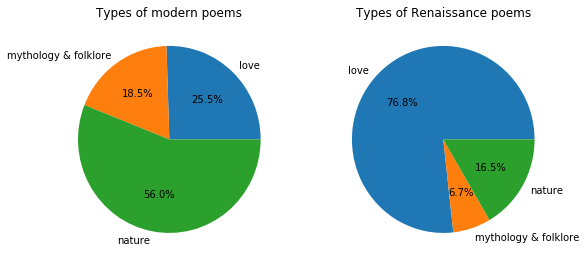

In [33]:
# create two pie charts showing the proportion of each type in modern & rennaisance poems respectively
mod_type = poems[poems.age=='modern'].groupby('type').size()
ren_type = poems[poems.age=='renaissance'].groupby('type').size()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4.3))
axes[0].pie(mod_type, labels=mod_type.index, autopct='%1.1f%%')
axes[0].set_title("Types of modern poems")
axes[1].pie(ren_type, labels=mod_type.index, autopct='%1.1f%%')
axes[1].set_title("Types of Renaissance poems")
plt.show()

More than half of the modern poems are of type 'nature', while the proportion for Renaissance poems is only 16.5%. It proved my guess that the keywords of poems are related with their types. In the next section, I compared poems based on their types.

## Comparing types


I selected the type "love" to investigate. I chose to do the comparison within each age respectively; otherwise the word frequencies would be influenced by the age difference, which is not of my interest at this moment. I compared the word frequencies of love poems with that of the other two types of poems in each age group.

In [34]:
# word frequency for modern poems of type 'love'
mod_love = word_freq(poems, (poems.type =='love') & (poems.age=='modern'))
# word frequency for modern poems of other two types
mod_others = word_freq(poems, (poems.type !='love') & (poems.age=='modern'))

# merge modern love poems with other two types of modern poems
mod_love_word = mod_love.merge(mod_others, how='left', on=['word','tag'], suffixes=['_love','_others'])
mod_love_word.fillna(0, inplace=True)
# compute log-odds
mod_love_word['log_odds'] = log_odds(mod_love_word.freq_love, mod_love_word.freq_others)
# show the highest log-odds values
mod_love_word[mod_love_word.freq_love >= 5].sort_values('log_odds').tail(20)

,word,freq_love,tag,freq_others,log_odds
114,room,9,NOUN,3.0,1.964397
470,calling,7,VERB,2.0,2.028935
991,music,10,NOUN,3.0,2.059707
1566,dey,5,NOUN,1.0,2.146718
1553,dat,12,NOUN,3.0,2.226761
832,baby,6,NOUN,1.0,2.300869
634,welcome,6,NOUN,1.0,2.300869
367,shy,8,NOUN,1.0,2.552183
316,enough,8,ADV,1.0,2.552183
1564,daih,5,NOUN,0.0,2.839866


The output shows the twenty words that are most likely to occur in modern love poems instead of other types of modern poems. It is interesting that many of these words don't appear to be directly related with romantic theme, such as "jump" and "scream". A few of them do correspond to our expectation of what a love poem may include, like "honey" "baby" and "shy".   
Then I compared the word frequency between love and other types of Renaissance poems using the same method.

In [35]:
# word frequency for Renaissance poems of type 'love'
ren_love = word_freq(poems, (poems.type =='love') & (poems.age=='renaissance'))
# word frequency for Renaissance poems of other types
ren_others = word_freq(poems, (poems.type !='love') & (poems.age=='renaissance'))

# merge Renaissance love poems with other two types of Renaissance poems
ren_love_word = ren_love.merge(ren_others, how='left', on=['word','tag'], suffixes=['_love','_others'])
ren_love_word.fillna(0, inplace=True)
# compute log-odds
ren_love_word['log_odds'] = log_odds(ren_love_word.freq_love, ren_love_word.freq_others)
# 20 largest log odds
ren_love_word[ren_love_word.freq_love >= 5].sort_values('log_odds').tail(20)

,word,freq_love,tag,freq_others,log_odds
160,vain,25,NOUN,2.0,1.644930
577,yett,8,NOUN,0.0,1.682670
2143,unhappy,8,ADJ,0.0,1.682670
639,nott,8,NOUN,0.0,1.682670
685,sweetly,8,ADV,0.0,1.682670
374,except,8,ADP,0.0,1.682670
491,says,8,VERB,0.0,1.682670
1130,heavy,9,ADJ,0.0,1.788031
2617,gup,9,NOUN,0.0,1.788031
556,butt,9,NOUN,0.0,1.788031


There are even more words that seem to be the opposite to what we would expect of love poems, including "fears" "woe" "unhappy" "vain". The keyword "love" does not appear in either modern or Renaissance love poems. It suggests that poets tend not to address the romantic theme explicitly but rather use circuitous styles. It also reveals the difficulty for us to determine what the poem is about by simply looking at the keywords, which may not directly reflect the topic, while the directly related keywords are usually not used by poets. 

This time I used bigrams instead of individual words to compare love poems with other types. I defined a function to compute the bigram frequencies by modifying the word_freq function. Then I applied it to the data frame. After merging two data frames, I simply computed the frequency difference between love poems and other types instead of using log-odds as the indicator.

In [36]:
def bigram_freq(df, condition):
    words = '\n'.join(df[condition].poem)                # create a long string of all poems from the input age
    tokens = [word for word in nltk.word_tokenize(words) if word.isalpha()]  # tokenize words and exclude punctuations
    bigrams = nltk.ngrams(tokens, 2)                     # get the bigrams from tokens
    df = pd.Series(nltk.FreqDist(bigrams)).reset_index() # convert to a dataframe
    df.columns = ['word1','word2','freq']                # set column names
    df = df[(df.word1.str.isalpha()) & (df.word2.str.isalpha())] # eliminate punctuations
    df['freq'] = df.freq/df.freq.sum()                   # normalize the frequency
    return(df)

In [37]:
# bigram frequency for modern poems of type 'love'
mod_love = bigram_freq(poems, (poems.type =='love') & (poems.age=='modern'))
# bigram frequency for modern poems of type 'love'
mod_others = bigram_freq(poems, (poems.type !='love') & (poems.age=='modern'))
# compare modern love poems with other two types of modern poems
mod_love_gram = mod_love.merge(mod_others, how='left', on=['word1','word2'], suffixes=['_love','_others'])
mod_love_gram.fillna(0, inplace=True)
# the frequency difference between love poems and other types
mod_love_gram['diff'] = mod_love_gram['freq_love'] - mod_love_gram['freq_others']
# 20 words with largest difference
mod_love_gram.sort_values('diff').tail(20)

,word1,word2,freq_love,freq_others,diff
89,to,be,0.001151,0.000323,0.000828
1414,will,be,0.001036,0.000206,0.000830
2062,to,her,0.000921,0.000088,0.000833
716,in,a,0.002302,0.001469,0.000833
211,do,not,0.001151,0.000294,0.000857
6401,i,remember,0.000921,0.000059,0.000862
1174,you,and,0.000921,0.000029,0.000891
1517,even,when,0.000921,0.000029,0.000891
146,my,heart,0.001151,0.000235,0.000916
1780,have,been,0.001151,0.000235,0.000916


Compared to words, the bigrams do not provide as much content information. Nevertheless, we can have a glimpse at the word patterns that feature love poems. For instance, many first-person and second-person pronouns are used. Then I applied the same method to look at the patterns of Renaissance love poems.

In [38]:
ren_love = bigram_freq(poems, (poems.type =='love') & (poems.age=='renaissance'))
ren_others = bigram_freq(poems, (poems.type !='love') & (poems.age=='renaissance'))
# compare modern love poems with other two types of modern poems
ren_love_gram = ren_love.merge(ren_others, how='left', on=['word1','word2'], suffixes=['_love','_others'])
ren_love_gram.fillna(0, inplace=True)
ren_love_gram['diff'] = ren_love_gram['freq_love'] - ren_love_gram['freq_others']
ren_love_gram.sort_values('diff').tail(20)

,word1,word2,freq_love,freq_others,diff
4844,i,do,0.000529,0.000128,0.000401
667,i,love,0.000404,0.000000,0.000404
3701,i,must,0.000498,0.000085,0.000413
1634,all,my,0.000560,0.000128,0.000432
4106,in,vain,0.000498,0.000043,0.000455
430,i,am,0.000840,0.000383,0.000457
59,let,me,0.000560,0.000085,0.000475
3162,her,eyes,0.000498,0.000000,0.000498
156,it,is,0.000995,0.000468,0.000528
746,and,i,0.000871,0.000340,0.000531


Most of the bigrams involve the first-person pronoun in different forms. We can conclude that poets tend to employ first-person perspective to express their feelings in love poems, particularly for Renaissance poets: they use phrases like "my heart" "my love" and "let me..." to speak their minds. Interestingly, the keyword "love" eventually appears in the bigram list for multiple times. Generally, the bigrams correspond to my expectation of typical love poems better than the word list.

## Comparing poets

### Renaissance poets (Shakespeare, Donne, Sidney, Spenser)

I decided to look at the work of specific poets. I selected four poets from Renaissance who have most poems in our dataset: William Shakespeare, John Donne, Sir Philip Sidney, and Edmund Spenser. I attempted to compare their word frequencies to the overall word frequencies in Renaissance poems. I needed to normalize the frequencies to proportions, so I modified the word_freq function.

In [39]:
def word_freq(df, condition):
    # create a long string of all poems from the input age
    words = '\n'.join(df[condition].poem)
    # tokenize words and exclude punctuations
    words = [word for word in nltk.word_tokenize(words) if word.isalpha()] 
    df = pd.Series(nltk.FreqDist(words)).reset_index()
    df.columns = ['word','freq']
    # add the tags to dataframe
    df['tag'] = df.word.apply(lambda x: nltk.pos_tag([x], tagset="universal")).apply(lambda x: x[0][1])
    # normalize frequency
    df.freq = df.freq/df.freq.sum()
    return(df)

I applied the word_freq function to each of four poets.

In [40]:
shake = word_freq(poems, poems.poet.str.contains("shakespeare"))
donne = word_freq(poems, poems.poet == 'john donne')
sidney = word_freq(poems, poems.poet.str.contains('sidney'))
spenser = word_freq(poems, poems.poet.str.contains('spenser'))

I merged word frequencies of four poets and Renaissance poems in to one dataframe. 

In [41]:
merged = donne.merge(
    shake, on = ['word','tag'], how = 'left', suffixes = ('_donne','_shake')).merge(
    sidney, on = ['word','tag'], how = 'left').merge(
    spenser, on = ['word','tag'], how = 'left', suffixes = ('_sydney','_spenser')).merge(
    ren, on = ['word','tag'], how = 'left')
# normalize the word freq
merged.freq = merged.freq/merged.freq.sum()
# add suffix to the column name
merged.rename({'freq':'freq_ren'}, axis=1, inplace=True)
merged.fillna(0, inplace = True)
merged.head()

,word,freq_donne,tag,freq_shake,freq_sydney,freq_spenser,freq_ren
0,when,0.005276,ADV,0.006306,0.000750,0.003720,0.005491
1,by,0.006048,ADP,0.004798,0.004124,0.003080,0.005538
2,thy,0.007850,NOUN,0.010281,0.007123,0.004126,0.008495
3,scorn,0.000386,NOUN,0.000137,0.000937,0.000116,0.000352
4,o,0.000901,NOUN,0.002742,0.005061,0.001162,0.002182


Now we can horizontally compare the frequency for each word among four poets. I selected the twenty most frequent nouns in Renaissance poems and plotted their frequencies in each poet's work.

In [42]:
a = merged[merged.tag=='NOUN'].sort_values('freq_ren').tail(20)
a

,word,freq_donne,tag,freq_shake,freq_sydney,freq_spenser,freq_ren
200,night,0.000643,NOUN,0.000822,0.000562,0.001685,0.001549
832,mine,0.001416,NOUN,0.002330,0.002062,0.000465,0.001666
451,world,0.002574,NOUN,0.001645,0.000375,0.001104,0.001713
726,unto,0.000643,NOUN,0.000685,0.000562,0.002499,0.001737
196,light,0.001158,NOUN,0.000137,0.002249,0.002267,0.001995
429,beauty,0.000386,NOUN,0.001782,0.002812,0.001627,0.002018
695,time,0.000772,NOUN,0.004112,0.001874,0.000756,0.002089
4,o,0.000901,NOUN,0.002742,0.005061,0.001162,0.002182
223,heart,0.001158,NOUN,0.002879,0.005248,0.000581,0.002253
189,day,0.001930,NOUN,0.001782,0.000562,0.002732,0.002276


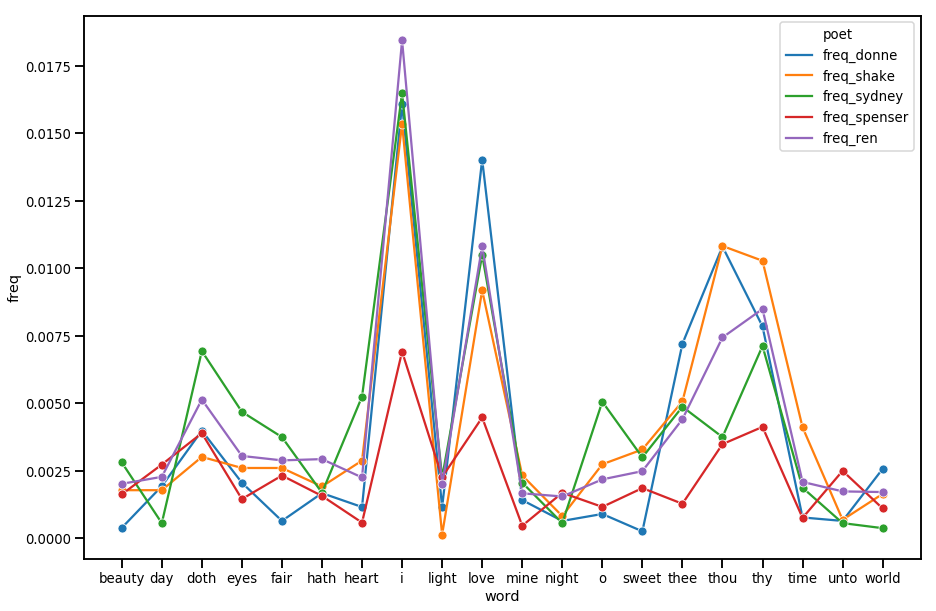

In [43]:
# convert the dataframe into long form
a = a.melt(id_vars=['word'], 
           value_vars=['freq_donne','freq_shake','freq_sydney','freq_spenser','freq_ren'], 
           var_name='poet', 
           value_name='freq')
# plot the word frequencies
plt.figure(figsize=(15,10))
sns.set_context("talk", font_scale=0.8)
sns.lineplot(x= 'word', y='freq', hue='poet', data=a, marker="o")

From the plot we can see the frequencies of the 20 most common Renaissance nouns in four poets' poems respectively. The purple line also shows the average frequency in Renaissance poems. The first thing I noticed is that in Spenser's poem (the red line) the word frequencies are generally lower than those in other poets' poems as well as the average, including words like "I" "love" and "thou" that are very frequent in other poems. My speculation is that he uses more unique words in his poems than other poets so that each word takes less proportion. Another possibility is that the topics or styles of his poems differ greatly from those of others so that he uses very different words. I decided to investigate this issue a little to prove my guess.  
  
  For the other three poets, there are no prominent differences despite certain degrees of variation. In particular, Shakespeare's word frequencies (the yellow line) seem to correspond with the average of Renaissance poems (purple) pretty well. This should not be surprising, for Shakespeare's poems occupy the largest proportion in our dataset: in the total of 284 Renaissance poems, 62 are by him (more than 1/5). It is reasonable that his poems have a considerable influence on the average word frequency due to the larger weight. 
  
I took a look at the total number of unique words in Spenser's poems and that of Shakespeare's.

In [44]:
len(spenser)

4126

In [45]:
len(shake)

1997

The result shows that there are 4126 unique words in Spenser's poems: more than twice as much as those in Shakespeare's. It seems that my first speculation is true. Can I conclude that Spenser's vocabulary is significantly larger than Shakespeare's? I decided to look at the length of each poem by both poets.

In [46]:
# length of Spenser's poems
spens_len = poems[poems.poet.str.contains('spenser')].poem.apply(lambda x: len(x))
spens_len.sort_values()

98       121
99       582
223      594
110      599
104      600
102      603
100      604
222      605
220      607
111      610
221      613
218      615
219      616
106      616
103      624
83       630
101      639
109      641
108      642
97       650
105      654
107      661
262     1082
12      4058
25      4283
15      5619
14      6578
13      7567
224    12758
10     18201
3      24710
Name: poem, dtype: int64

In [47]:
# length of Shakespeare's poems
shake_len = poems[poems.poet.str.contains('shakespeare')].poem.apply(lambda x: len(x))
shake_len.sort_values()

65       34
26      226
282     237
64      276
63      329
       ... 
40      791
176     946
39     1452
0      2130
171    3764
Name: poem, Length: 62, dtype: int64

In [48]:
print("Total length(Spenser):", spens_len.sum())
print("Total length(Shakespeare):",shake_len.sum())
print("Average length(Spenser):", spens_len.sum()/len(spens_len))
print("Average length(Shakespeare):", shake_len.sum()/len(shake_len))

Total length(Spenser): 97982
Total length(Shakespeare): 41746
Average length(Spenser): 3160.7096774193546
Average length(Shakespeare): 673.3225806451613


While the longest poem by Shakespeare contains 3764 words, several of Spenser's poems are much longer, including three poems that contain more than 10,000 words. Thus, the average of their poems' lengths differ greatly. Spenser's poems are about four times longer than Shakespeare's on average. This can be explained by the fact that Spenser is famous for his epics, which are long narrative poems, while Shakespeare mostly writes sonnets instead of longer poems. 

In [49]:
poems.title[3] # the title of the longest of Spenser's poems

'from the faerie queene: book i, canto i'

The longest one of Spenser's poems is from his epic poem *Faerie Queene* --"one of the longest poems in the English language"([Wikipedia](https://en.wikipedia.org/wiki/The_Faerie_Queene)). It proves that longer texts of Spenser's are included in our dataset because of the nature of their genre. It also turned out that my claim "Shakespeare's poems occupy the largest proportion in our dataset" is inaccurate, since the largest number of poems do not entail the largest portion of texts in the corpus. I should consider the lengths of the poems instead of the amount.

I converted the frequency columns to their difference between the average. Then I visualized the 25 most distinctive nouns for each poet.

freq_donne


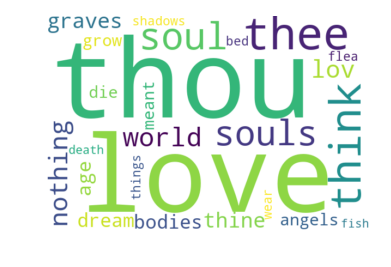

freq_shake


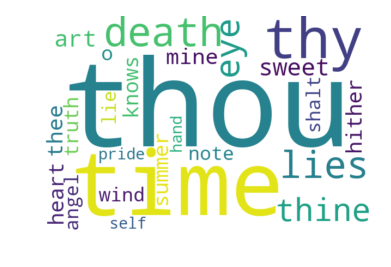

freq_sydney


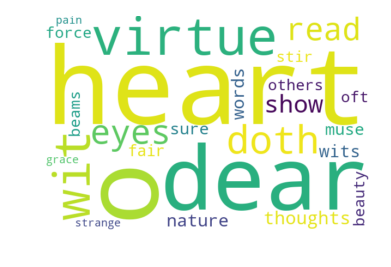

freq_spenser


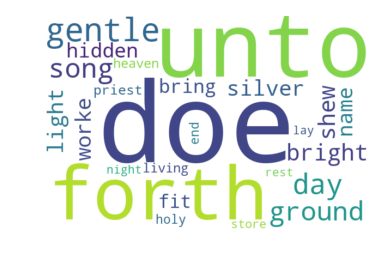

In [50]:
# create word cloud for each poet
for col in ['freq_donne','freq_shake','freq_sydney','freq_spenser']:
    merged[col] = merged[col] - merged['freq_ren']
    print(col)
    df = merged[merged.tag=='NOUN'].sort_values(col).tail(25)
    wordcloud(df, 'word',col)

## Conclusion

In this project, I mainly used keywords extraction by computing word frequencies to compare poems of different ages, types, and authors. The most common words associated with each age demonstrate both a change in word forms and a shift in poetic imagery of poets’ interests from Renaissance to modern times. When investigating poem types, I compared both word frequencies and bigram frequencies. It turned out that the latter works better in reflecting the patterns of typical love poems while the former ones seem to be more vague and indirect. In the end, I compared the word frequencies of four Renaissance poets in an attempt to gain some insights on their styles. During the process, I discovered the surprisingly low word frequencies of Spenser’s poems and then by some analysis found out the reason: the exceptional lengths of his epics. In the end I presented the words that characterize each poet’s works; Though not perfect, they do allow us to take a glimpse into the features of their poems.  
  
  This project is a great opportunity for me to apply what I have learned in the class to different data and to try new things at the same time. I got to practice my skills for data wrangling, especially when I use another dataset to extract the missing information. Even though we can examine the data beforehand, sometimes the problems cannot be detected until we encounter errors later in the middle of our analysis. So it is important to keep an eye on potential problems and pause to solve them when necessary. I also used different ways to visualize data, including word clouds which I have never tried before. I was able to search for information about a new method and apply it to my data after making adjustments. I believe that appropriate visualizations can help us interpret the result and get insights out of it in more easily.   
    
   This project is merely an experiment that includes some exploratory analysis of poetry data using computational methods. Due to the characteristics of poetry as a genre, it is difficult to obtain the exact topic of a poem from the keywords, while the Wikipedia articles, which we worked with in our assignments, would be an opposite example since the keywords (usually proper nouns) are explicitly related to the topic. The styles of poets are also difficult to determine when the definition of “style” itself remains obscure and controversial. Nevertheless, it does offer some different, interesting perspectives by studying poems in an untraditional way. One thing crucial is that the output of machines must be effectively combined with human judgment and interpretations.   
  
  One way to develop the project further could be to use machine learning methods to develop a classification model to predict the age, type, and author of a poem. It would be not only interesting but also useful in investigating some actual questions. For a text with unknown or controversial author, we can use the model to determine its real authorship.

## Experimentation

I experimented with a feature extraction technique. I used code that was originally used to analyze Yelp reviews.

In [85]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
ENGLISH_STOP_WORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [70]:
def normalize(text):
    text = [word for word in nltk.word_tokenize(text) if word not in ENGLISH_STOP_WORDS if word.isalpha()] 
    text = ' '.join(text)
    return(text)

text = poems.poem.apply(normalize)
len(text)

484

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text).T
print(X.shape)

(12687, 484)


In [72]:
## Non-negative Matrix Factorization
def non_negative_marix_decomp(n_components,train_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, 
                     init='nndsvda', max_iter=500, 
                     random_state=0)
    W = model.fit_transform(train_data)
    H = model.components_
    nmf = (W,H)
    return(nmf)

In [92]:
feature_names = vectorizer.get_feature_names()

r = 10 # no. of topics
W_topic8, H_topic8 = \
    non_negative_marix_decomp(n_components = r, train_data = X)

In [93]:
def extract_topic_top_words(W, all_words, num_top_words=10):
  
    num_words, num_topics = W.shape
    
    assert num_words == len(all_words)
    
    for t in range(0, num_topics):
        top_words_idx = np.argsort(W[:,t])[::-1]  # descending order
        top_words_idx = top_words_idx[:num_top_words]
        top_words = [all_words[k] for k in top_words_idx]
        top_words_shares = W[top_words_idx, t]
        print('# Topic', t+1)
        for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
            print(word, share)
        print('\n')
        
extract_topic_top_words(W_topic8, feature_names)

# Topic 1
love 0.7773580033670505
true 0.16380070839721886
loves 0.14533261395604982
loved 0.11491921048148879
did 0.09827853768553449
let 0.09481383768573945
blind 0.07822317623464199
come 0.07480677460217507
man 0.072563083119299
old 0.0684187400889796


# Topic 2
thy 1.4155326224061833
thou 0.3641848755996001
whilst 0.24726290715933938
think 0.188533427087563
thee 0.14322010716015338
care 0.1250998753418773
world 0.12187228793495941
thine 0.1148913028648696
fading 0.10958522037899476
love 0.09799889861622585


# Topic 3
like 0.407445573192908
wind 0.24752687139039858
water 0.22489503796202678
sea 0.22031938614063928
little 0.20324783369244312
old 0.20003394611933742
dark 0.19466822951729176
air 0.19280600161110645
man 0.1831064182541425
sun 0.17427168180404123


# Topic 4
ye 1.0859774987555262
nay 0.16642460572062626
fair 0.12525665450024445
mule 0.11960801847116698
shall 0.11826650170086764
key 0.1001753252308938
leave 0.09632885539212581
happy 0.09226713003882041
answer 0.09163814

In [94]:
num_topics, num_reviews = H_topic8.shape

H8df = pd.DataFrame(H_topic8, 
                     index=['topic'+str(one) for one in range(1, num_topics+1)], 
                     columns=['poem'+str(one) for one in range(1, num_reviews+1)])
H8df

,poem1,poem2,poem3,poem4,poem5,poem6,poem7,poem8,poem9,poem10,...,poem475,poem476,poem477,poem478,poem479,poem480,poem481,poem482,poem483,poem484
topic1,0.153301,0.007342,0.009299,0.034374,0.128682,0.061645,0.000560,0.000000,0.001058,0.000000,...,0.000779,0.184594,0.000000,0.017043,0.000000,0.000000,0.000000,0.000000,0.136281,0.232383
topic2,0.001442,0.000000,0.050638,0.025038,0.002289,0.000612,0.009789,0.005171,0.033263,0.000000,...,0.002507,0.000000,0.000000,0.000000,0.000000,0.004246,0.000000,0.000000,0.000000,0.000000
topic3,0.009189,0.006706,0.025058,0.055497,0.003453,0.024280,0.004700,0.000000,0.000000,0.014870,...,0.028202,0.050075,0.119343,0.108545,0.026644,0.077782,0.078292,0.108561,0.057587,0.030335
topic4,0.000000,0.000000,0.000000,0.117720,0.009367,0.000766,0.002783,0.015312,0.000000,0.084053,...,0.006133,0.000000,0.000000,0.009893,0.000000,0.000860,0.000205,0.000000,0.000000,0.000000
topic5,0.100735,0.000000,0.000000,0.006993,0.000000,0.000000,0.000000,0.000000,0.389639,0.001997,...,0.000000,0.000000,0.000000,0.007627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic6,0.091999,0.032213,0.021866,0.082069,0.000000,0.002138,0.126895,0.034868,0.000000,0.020818,...,0.003315,0.000000,0.015348,0.029085,0.000000,0.006012,0.000904,0.000000,0.000000,0.000000
topic7,0.000000,0.000000,0.000000,0.018671,0.000000,0.022833,0.000000,0.026598,0.000000,0.000000,...,0.005784,0.000000,0.005903,0.038274,0.048703,0.000000,0.001616,0.000000,0.046924,0.036504
topic8,0.000000,0.000000,0.000000,0.013896,0.000527,0.000000,0.000883,0.030282,0.047232,0.000000,...,0.000000,0.080115,0.000000,0.054314,0.254426,0.000000,0.006038,0.000000,0.000000,0.000000
topic9,0.000000,0.080647,0.000000,0.185563,0.005353,0.000000,0.000000,0.144168,0.000000,0.003324,...,0.005566,0.000000,0.000000,0.005338,0.000000,0.032811,0.001948,0.044516,0.000000,0.000000
topic10,0.001058,0.007771,0.000000,0.014751,0.000000,0.088119,0.000000,0.000000,0.000000,0.000000,...,0.003160,0.032142,0.008159,0.000000,0.054169,0.000239,0.030976,0.000000,0.000000,0.004213


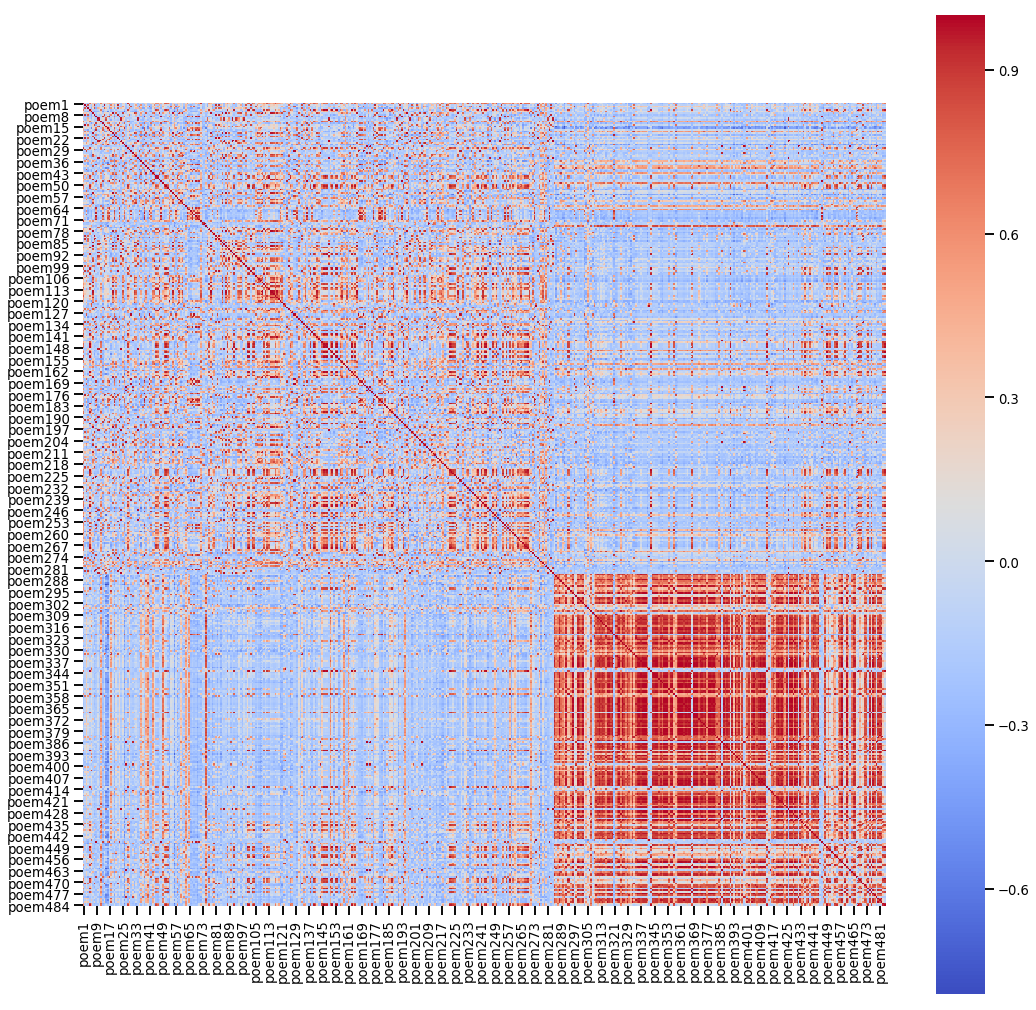

In [95]:
review_corr = H8df.corr()

%matplotlib inline

plt.figure(figsize=(18,18))
ax = sns.heatmap(review_corr, square=True, cmap="coolwarm");

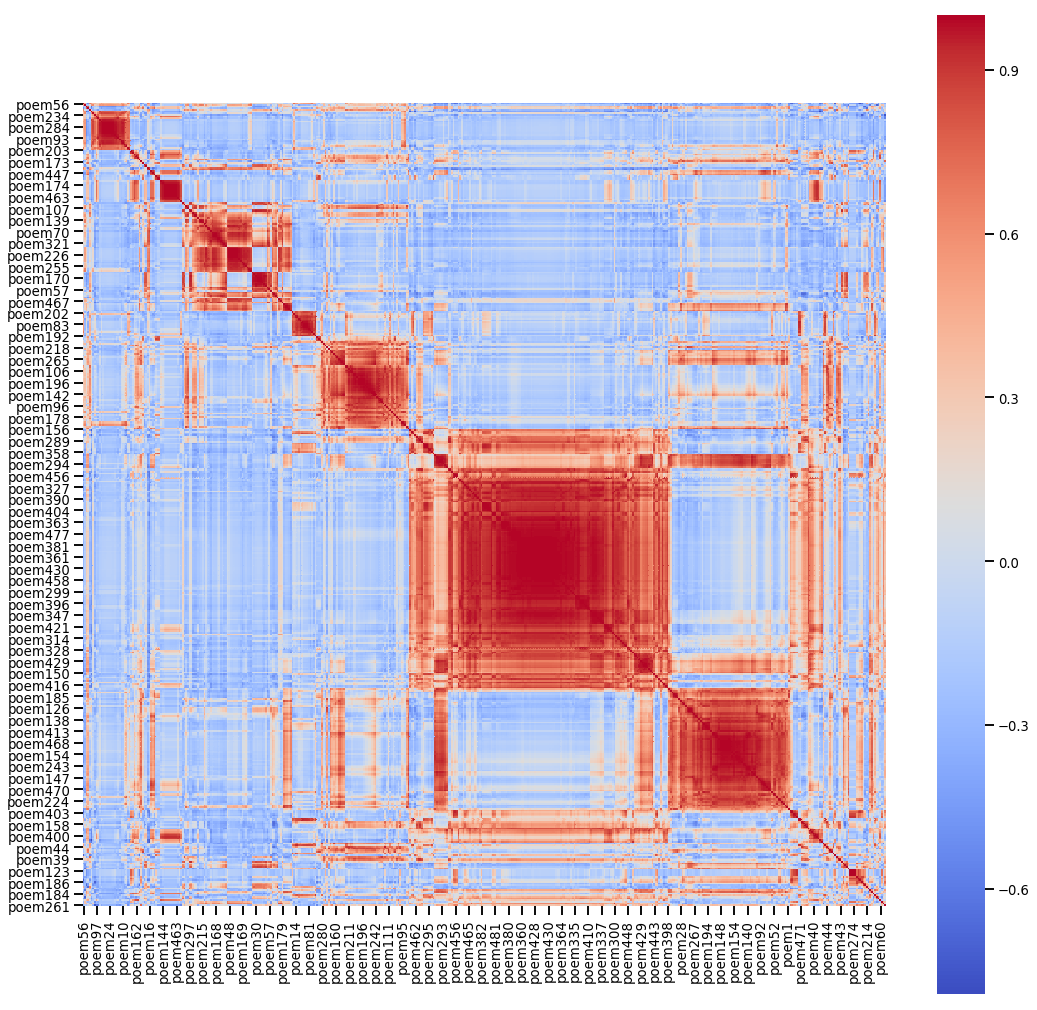

In [96]:
from scipy.cluster.hierarchy import linkage, leaves_list
review_linkage = linkage(review_corr.transpose(), optimal_ordering=True)
leave_ord = leaves_list(review_linkage)

plt.figure(figsize=(18,18))
sns.heatmap(review_corr.iloc[leave_ord, leave_ord], square=True, cmap="coolwarm")